# Importing Data

In [1]:
import os
import gc
import re
import cv2
import sys
import glob
from glob import glob
import tensorflow as tf
import keras

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style  as style

from tqdm  import tqdm
from keras import backend
from sklearn.metrics     import accuracy_score, roc_auc_score
from keras.layers        import Dense, Dropout, Flatten, BatchNormalization, GlobalMaxPooling2D
from keras.models        import Sequential, Model, load_model
from keras.callbacks     import ModelCheckpoint,ReduceLROnPlateau, CSVLogger
from keras.activations   import elu
from keras.engine        import Layer, InputSpec
from keras.applications  import MobileNetV2
from keras.optimizers    import Adam
from keras.preprocessing import image
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.mobilenetv2 import preprocess_input, decode_predictions

In [2]:
# Compose filenames
filelist_mt = glob('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/*.png')
filelist_shenzen     = glob('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/*.png')
filelist             = filelist_mt + filelist_shenzen

In [3]:
j = 0
for i in filelist:
    print(i)
    if j == 5:
        break
    j+=1

../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0017_0.png
../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0020_0.png
../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0030_0.png
../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0013_0.png
../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0354_1.png
../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0044_0.png


In [4]:
def extract_label(file_list):
    '''
    Label Extraction Function
    Reads a filename and extracts label from it
    '''
    labels = []
    for file in tqdm(file_list):
        current_label = re.findall('[0-9]{4}_(.+?).png', file)
#         print(current_label)
        labels.append(current_label[0])
    return(labels)

In [5]:
label = extract_label(filelist)

100%|██████████| 800/800 [00:00<00:00, 172631.74it/s]


In [6]:
len(label)

800

In [7]:
df = pd.DataFrame(filelist, columns = ['Path'])
df['Label'] = label

y = df['Label']
X = df.drop(['Label'], axis = 1)
X.shape, y.shape

((800, 1), (800,))

# Splitting Data

We will first split the data into 80% for Training and 20% for Testing
Then, we will split the Training data (again) for 80% Training and 20% Validation.

It is important to divide the data into 3 parts, so that we can have data for both testing (unseen data) and validation

In [8]:
#80% Training 20% Testing
df_train, X_test, label_train, y_test = train_test_split(X,
                                                         y,
                                                         stratify = y,
                                                         random_state = 19,
                                                         test_size = 0.2)

In [9]:
# 80% Training 20% Validation
X_train, X_valid, y_train, y_valid = train_test_split(df_train,
                                                     label_train,
                                                     stratify = label_train,
                                                     random_state = 19,
                                                     test_size = 0.2)

In [10]:
print('Train size')
print(X_train.shape, y_train.shape)
print('Validation Size')
print(X_valid.shape, y_valid.shape)
print('Testing Size')
print(X_test.shape, y_test.shape)

Train size
(512, 1) (512,)
Validation Size
(128, 1) (128,)
Testing Size
(160, 1) (160,)


For easier dataframe usage, we will make them into each dataframe

In [11]:
# Train
train_df = X_train.copy()
train_df['Label'] = y_train


#Valid
valid_df = X_valid.copy()
valid_df['Label'] = y_valid


#Test
test_df = X_test.copy()
test_df['Label'] = y_test


In [12]:
train_df.head()

,Path,Label
761,../input/pulmonary-chest-xray-abnormalities/Ch...,1
577,../input/pulmonary-chest-xray-abnormalities/Ch...,1
484,../input/pulmonary-chest-xray-abnormalities/Ch...,0
299,../input/pulmonary-chest-xray-abnormalities/Ch...,0
99,../input/pulmonary-chest-xray-abnormalities/Mo...,1


# Exploratory Data Analysis

In [13]:
print("Train Value Counts")
print(train_df['Label'].value_counts())
print("Validation DF Value Counts")
print(valid_df['Label'].value_counts())
print("Test DF Value Counts")
print(test_df['Label'].value_counts())

Train Value Counts
0    260
1    252
Name: Label, dtype: int64
Validation DF Value Counts
0    65
1    63
Name: Label, dtype: int64
Test DF Value Counts
0    81
1    79
Name: Label, dtype: int64


The label seems to be well distributed, so we will use accuracy, ROC, and Recall as our main metrics. We would want to prevent any wrong prediction of people with Pneumonia. Hence, Recall metric is important

In [14]:
def plot_multiple_images(image_dataframe, rows = 4, columns = 4, figsize = (16, 20), resize=(1024,1024), preprocessing=None):
    '''
    Plots Multiple Images
    Reads, resizes, applies preprocessing if desired and plots multiple images from a given dataframe
    '''
    image_dataframe = image_dataframe.reset_index(drop=True)
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
#     print(image_dataframe)
    i = 1
    for j in range(rows):
        for k in range(columns):
            img = plt.imread(image_dataframe.loc[i-1,'Path'])
            img = cv2.resize(img, resize)
            if preprocessing:
                img = preprocessing(img)
            ax[j][k].set_title("Xray "+str(i))
            a = image_dataframe.loc[i-1, 'Label']
            if int(a) == 0:
                ax[j][k].set_xlabel('Normal')
            else:
                ax[j][k].set_xlabel('Pneumonia')  
                
            ax[j][k].imshow(img, alpha=1, cmap='gray')
            i+=1
            
        if(i == (rows*columns)):
            break
    plt.show()

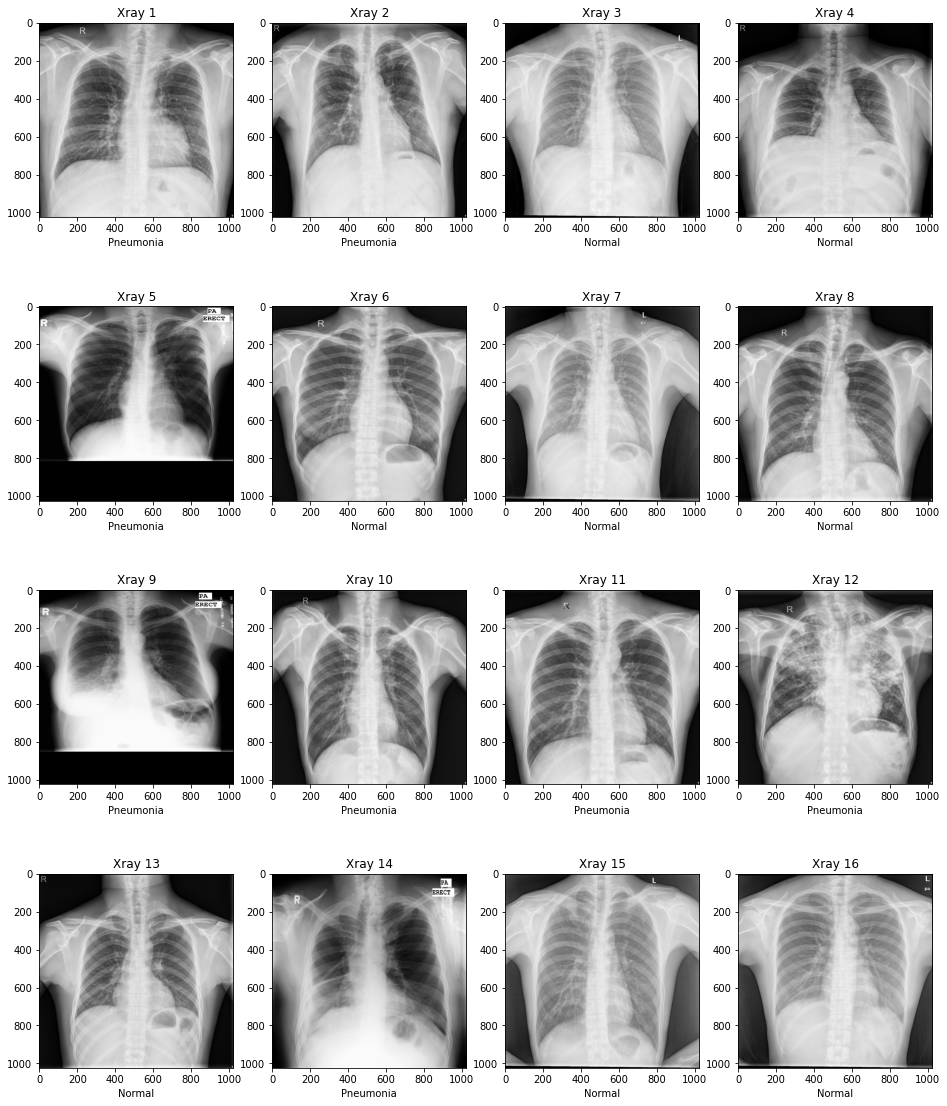

In [15]:
plot_multiple_images(train_df)

In [16]:
train_df.head()

,Path,Label
761,../input/pulmonary-chest-xray-abnormalities/Ch...,1
577,../input/pulmonary-chest-xray-abnormalities/Ch...,1
484,../input/pulmonary-chest-xray-abnormalities/Ch...,0
299,../input/pulmonary-chest-xray-abnormalities/Ch...,0
99,../input/pulmonary-chest-xray-abnormalities/Mo...,1


# Baseline Model

Making a baseline model is important to have a benchmark model, so that we can know how our new model improve each time we train it. We will use a batch size of 32, and image size of 224x224

In [17]:
BATCH = 32
IMAGE_INPUT = (224, 224)

We will use ImageDataGenerator from Keras, which functions to load some image (based on our BATCH size that we set) at a time.
Here we will only scale the image /255, so that it is between 0 and 255, because we only want to train our baseline model.

In [18]:
#Creating Training Data Generator
tf.random.set_seed(19)
train_generator = ImageDataGenerator(rescale = 1./255,)

# Create Validation data generator
test_generator  = ImageDataGenerator(rescale = 1./255,)

In [19]:
train = train_generator.flow_from_dataframe(dataframe = train_df,
                                    class_mode  = 'binary',
                                    x_col       = 'Path',
                                    y_col       = 'Label',
                                    shuffle     = True,
                                    batch_size  = BATCH,
                                    target_size = IMAGE_INPUT,
                                    seed=19)

valid = train_generator.flow_from_dataframe(dataframe = valid_df,
                                    class_mode  = 'binary',
                                    x_col       = 'Path',
                                    y_col       = 'Label',
                                    shuffle     = True,
                                    batch_size  = BATCH,
                                    target_size = IMAGE_INPUT,
                                    seed=19)

Found 512 validated image filenames belonging to 2 classes.
Found 128 validated image filenames belonging to 2 classes.


In [20]:
test = test_generator.flow_from_dataframe(dataframe = test_df,
                                    class_mode  = 'binary',
                                    x_col       = 'Path',
                                    y_col       = 'Label',
                                    shuffle     = False,
                                    batch_size  = BATCH,
                                    target_size = IMAGE_INPUT)


Found 160 validated image filenames belonging to 2 classes.


This shows that there will be 512 data for training and 128 data for validation, each having 2 classes, normal and with pneumonia

## Creating the baseline model

Now we can create the baseline cnn model

In [21]:
metrics=['accuracy','Precision', keras.metrics.Recall(), keras.metrics.AUC()]

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
baselineM = Sequential([
  keras.layers.Conv2D(filters=10, 
                      kernel_size=3, 
                      strides=1,
                      padding='valid',
                      activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  keras.layers.Conv2D(10, 3, activation='relu'),
  keras.layers.Conv2D(10, 3, activation='relu'),
  keras.layers.Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

baselineM.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate = 5e-4),
                metrics=[metrics])

baselineM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 218, 218, 10)      910       
_________________________________________________________________
flatten (Flatten)            (None, 475240)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 475241    
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


We also need to set a callback, to help us in getting better accuracy with efficient time usage.

In [23]:
%load_ext tensorboard

In [24]:
#Tensorflow Callback
%load_ext tensorboard
logdir = os.path.join("logs", "BaselineModel")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# We can also use customized callback, where we customize them on our own
class PrintValTrainRatioCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs): 
    print("val / train : {:.2f}".format(logs['val_loss']/logs['loss']))
    
#Another Additional callbacks (Checkpoint, Early Stopping)
checkpoint_cb = keras.callbacks.ModelCheckpoint("baseline_model.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True) 
callbacks = [tensorboard_callback, checkpoint_cb, early_stopping_cb, PrintValTrainRatioCallback()]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


We can now finally train our model

In [25]:
baseHistory = baselineM.fit(
            train,
            callbacks = [tensorboard_callback, checkpoint_cb, early_stopping_cb, PrintValTrainRatioCallback()],
            epochs    = 20,
            steps_per_epoch  = len(train),
            validation_data  = valid,
            validation_steps = len(valid))

baselineM = keras.models.load_model('baseline_model.h5')

Epoch 1/20
16/16 [==============================] - 146s 9s/step - loss: 2.0034 - accuracy: 0.4959 - precision: 0.4644 - recall: 0.5498 - auc: 0.4888 - val_loss: 0.6135 - val_accuracy: 0.6641 - val_precision: 0.6220 - val_recall: 0.8095 - val_auc: 0.7999
val / train : 0.41
Epoch 2/20
16/16 [==============================] - 70s 4s/step - loss: 0.6854 - accuracy: 0.5613 - precision: 0.5530 - recall: 0.8281 - auc: 0.6463 - val_loss: 0.6668 - val_accuracy: 0.5078 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8212
val / train : 0.98
Epoch 3/20
16/16 [==============================] - 69s 4s/step - loss: 0.6425 - accuracy: 0.6109 - precision: 0.8826 - recall: 0.2482 - auc: 0.8479 - val_loss: 0.5695 - val_accuracy: 0.8203 - val_precision: 0.8448 - val_recall: 0.7778 - val_auc: 0.8812
val / train : 0.91
Epoch 4/20
16/16 [==============================] - 70s 4s/step - loss: 0.5227 - accuracy: 0.8179 - precision: 0.8712 - recall: 0.7153 - auc: 0.8722 - val_loss: 0.4514 - va

We can see that the val/train loss is getting bigger and bigger each time the epoch ends. It can be concluded that this model is overfiting towards the training data

In [26]:
%tensorboard --logdir logs

In [27]:
def plot_training_hist(keras_model):
    '''
    Plot training History
    Creates two plots of model training logs
    '''
    hist = keras_model.history
    style.use('fivethirtyeight')
    
    # Loss Plot
    fig = plt.figure(figsize=(8,3))
    plt.title('Loss Plot')
    plt.plot(hist['loss'], '#07e9ed')
    plt.plot(hist['val_loss'], '#0791ed')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim([0,1.2 * max(max(hist['loss'], hist['val_loss']))])
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    
    # Accuracy Plot
    fig = plt.figure(figsize=(8,3))
    plt.title('Accuracy Plot')
    plt.plot(hist['accuracy'], '#07e9ed')
    plt.plot(hist['val_accuracy'], '#0791ed')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')    
    plt.legend(['train', 'validation'], loc='lower right')
    plt.ylim([0,1])
    
    #ROC Plot
    fig = plt.figure(figsize=(8,3))
    plt.title('AUC Plot')
    plt.plot(hist['auc'], '#07e9ed')
    plt.plot(hist['val_auc'], '#0791ed')
    plt.xlabel('Epochs')
    plt.ylabel('AUC Score')    
    plt.legend(['train', 'validation'], loc='lower right')
    plt.ylim([0,1])
    # Show Plot, reset style
    plt.show()
    style.use('default')

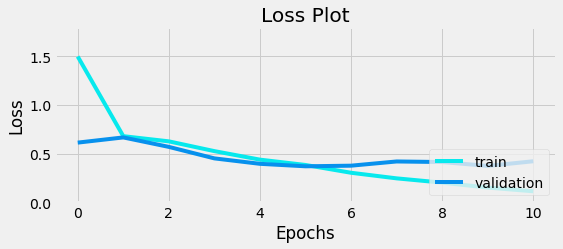

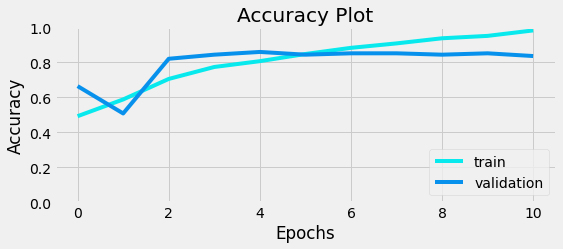

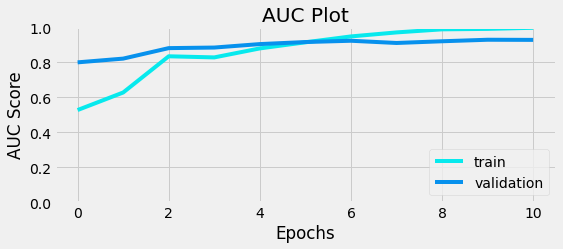

In [28]:
plot_training_hist(baseHistory)

It is quite good, but we can still improve it with augmented data. Augmented data has proven to help the model to be less overfit, and become a better one when predicting unseen dataset. 

# Augmented Training Data

Data augmentation plays a major role in making our data more diverse to prevent overfitting towards our model, especially when our dataset is small enough to be used on real world datasets.

In [29]:
train_df.shape

(512, 2)

We will still be using ImageDataGenerator to augment our training data

In [30]:
train_aug_generator = ImageDataGenerator(rescale = 1./255,
                                     zoom_range      = 0.05,
                                     shear_range     = 0,
                                     width_shift_range  = 0.05,
                                     height_shift_range = 0.05,
                                     )

train_aug = train_aug_generator.flow_from_dataframe(dataframe = train_df,
                                    class_mode  = 'binary',
                                    x_col       = 'Path',
                                    y_col       = 'Label',
                                    shuffle     = True,
                                    batch_size  = BATCH,
                                    target_size = IMAGE_INPUT,
                                    seed=19)

Found 512 validated image filenames belonging to 2 classes.


In [31]:
#Tensorflow Callback
%load_ext tensorboard
logdir = os.path.join("logs", "BaselineModel-Augment")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# We can also use customized callback, where we customize them on our own
class PrintValTrainRatioCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs): 
    print("val / train : {:.2f}".format(logs['val_loss']/logs['loss']))
    
#Another Additional callbacks (Checkpoint, Early Stopping)
checkpoint_cb = keras.callbacks.ModelCheckpoint("baseline_augment.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True) 
callbacks = [tensorboard_callback, checkpoint_cb, early_stopping_cb, PrintValTrainRatioCallback()]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Now we can retrain our new model with augmented data

In [32]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

baselineM2 = Sequential([
  keras.layers.Conv2D(filters=10, 
                      kernel_size=3, 
                      strides=1,
                      padding='valid',
                      activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  keras.layers.Conv2D(10, 3, activation='relu'),
  keras.layers.Conv2D(10, 3, activation='relu'),
  keras.layers.Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

baselineM2.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate = 5e-4),
                metrics=[metrics])

baselineM2.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 218, 218, 10)      910       
_________________________________________________________________
flatten (Flatten)            (None, 475240)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 475241    
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


In [33]:
baseHistory2 = baselineM2.fit(
            train_aug,
            callbacks = [callbacks],
            epochs    = 20,
            steps_per_epoch  = len(train),
            validation_data  = valid,
            validation_steps = len(valid))

baselineM2 = keras.models.load_model('baseline_augment.h5')

Epoch 1/20
16/16 [==============================] - 79s 5s/step - loss: 1.8603 - accuracy: 0.4736 - precision: 0.4542 - recall: 0.6734 - auc: 0.6367 - val_loss: 0.6642 - val_accuracy: 0.5391 - val_precision: 0.5172 - val_recall: 0.9524 - val_auc: 0.8038
val / train : 0.45
Epoch 2/20
16/16 [==============================] - 74s 5s/step - loss: 0.6779 - accuracy: 0.5655 - precision: 0.5572 - recall: 0.8506 - auc: 0.6388 - val_loss: 0.6314 - val_accuracy: 0.6016 - val_precision: 0.8000 - val_recall: 0.2540 - val_auc: 0.8225
val / train : 0.95
Epoch 3/20
16/16 [==============================] - 74s 5s/step - loss: 0.6283 - accuracy: 0.6255 - precision: 0.7174 - recall: 0.3953 - auc: 0.7558 - val_loss: 0.5697 - val_accuracy: 0.7500 - val_precision: 0.8974 - val_recall: 0.5556 - val_auc: 0.8393
val / train : 0.92
Epoch 4/20
16/16 [==============================] - 74s 5s/step - loss: 0.5778 - accuracy: 0.7280 - precision: 0.7876 - recall: 0.6116 - auc: 0.7854 - val_loss: 0.4995 - val_accurac

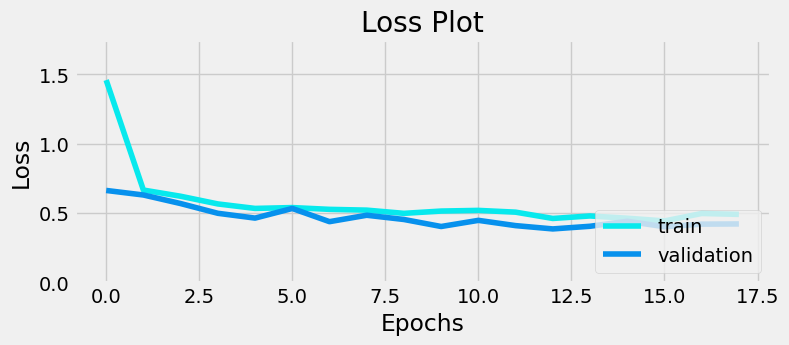

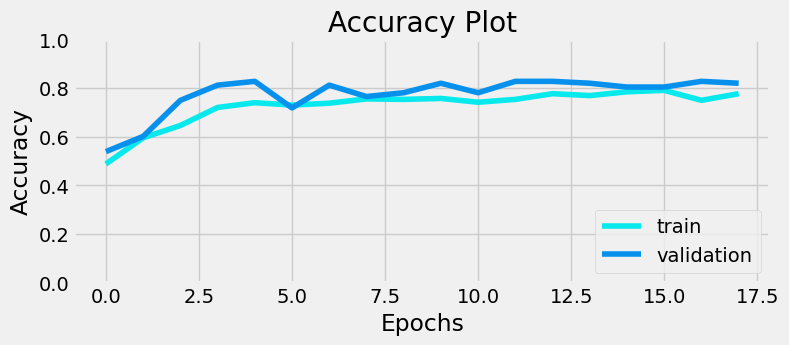

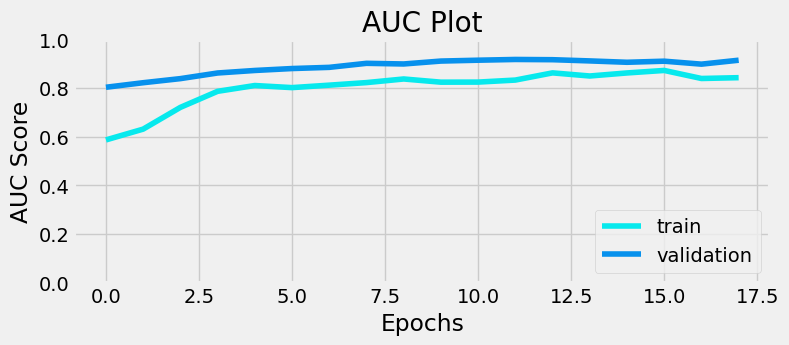

In [34]:
plot_training_hist(baseHistory2)

It is way better than the previous overfit model! So we will use this augmented dataset for other training too. From previous training, lowering the learning rate didn't give any major improvement. Hence, we will move on to the pretrained model

In [76]:
baselineM2.evaluate(valid)

4/4 [==============================] - 14s 4s/step - loss: 0.4227 - accuracy: 0.8203 - precision: 0.7703 - recall: 0.9048 - auc: 0.9151


[0.42270761728286743,
 0.8203125,
 0.7702702879905701,
 0.9047619104385376,
 0.9151403307914734]

# Use Pretrained Model

In [35]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

We will now use a pretrained model tu achieve a better result

In [36]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_INPUT+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='sigmoid', name='output_layer') # create our own output layer      
  ])

  return model

## ResNet50

Resnet50 URL

In [37]:
resnet50_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

In [38]:
#Tensorflow Callback
%load_ext tensorboard
logdir = os.path.join("logs", "resnet50")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# We can also use customized callback, where we customize them on our own
class PrintValTrainRatioCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs): 
    print("val / train : {:.2f}".format(logs['val_loss']/logs['loss']))
    
#Another Additional callbacks (Checkpoint, Early Stopping)
checkpoint_cb = keras.callbacks.ModelCheckpoint("resnet_model.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True) 
callbacks = [tensorboard_callback, checkpoint_cb, early_stopping_cb, PrintValTrainRatioCallback()]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [39]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

resnet_model = create_model(resnet50_url, 1)

# Compile
resnet_model.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-4),
                     metrics=[metrics])

In [40]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [41]:
resnet_history = resnet_model.fit(
            train_aug,
            callbacks = [callbacks],
            epochs    = 20,
            steps_per_epoch  = len(train),
            validation_data  = valid,
            validation_steps = len(valid))



Epoch 1/20
16/16 [==============================] - 82s 5s/step - loss: 0.7282 - accuracy: 0.5444 - precision: 0.5547 - recall: 0.6597 - auc: 0.7089 - val_loss: 0.6659 - val_accuracy: 0.5703 - val_precision: 0.5833 - val_recall: 0.4444 - val_auc: 0.6272
val / train : 0.94
Epoch 2/20
16/16 [==============================] - 75s 5s/step - loss: 0.6610 - accuracy: 0.6050 - precision: 0.6221 - recall: 0.5361 - auc: 0.6600 - val_loss: 0.5920 - val_accuracy: 0.6641 - val_precision: 0.6389 - val_recall: 0.7302 - val_auc: 0.7521
val / train : 0.93
Epoch 3/20
16/16 [==============================] - 71s 5s/step - loss: 0.6094 - accuracy: 0.6820 - precision: 0.6660 - recall: 0.6808 - auc: 0.7345 - val_loss: 0.5566 - val_accuracy: 0.6953 - val_precision: 0.6500 - val_recall: 0.8254 - val_auc: 0.8045
val / train : 0.94
Epoch 4/20
16/16 [==============================] - 73s 5s/step - loss: 0.5534 - accuracy: 0.7365 - precision: 0.7428 - recall: 0.7622 - auc: 0.8057 - val_loss: 0.5155 - val_accurac

In [42]:
# resnet_model = keras.models.load_model('resnet_model.h5')

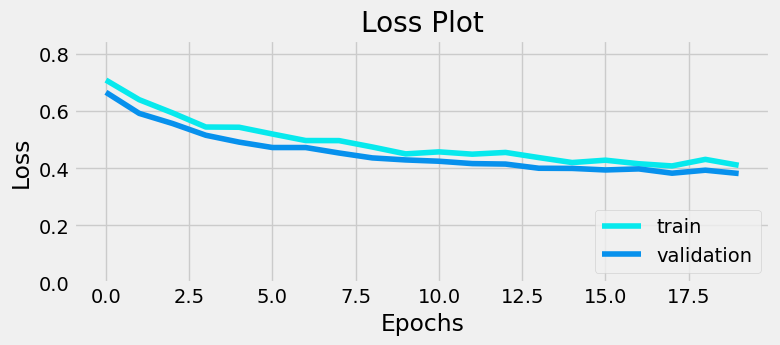

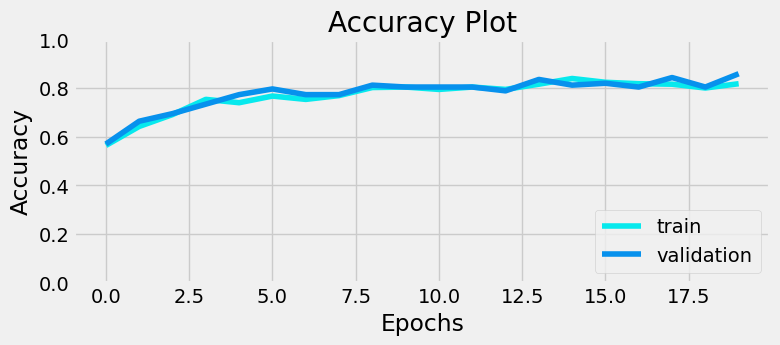

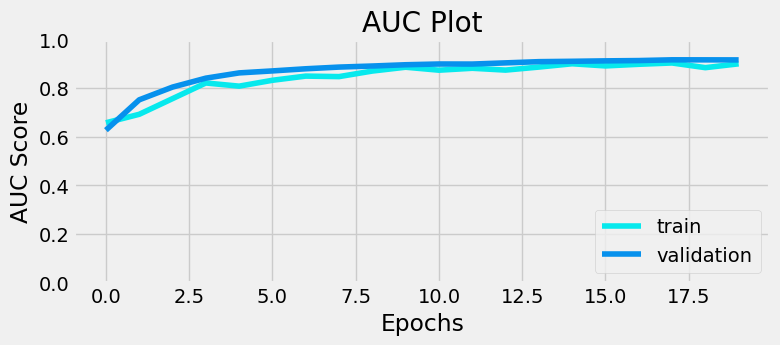

In [43]:
plot_training_hist(resnet_history)

In [75]:
resnet_model.evaluate(valid)

4/4 [==============================] - 14s 3s/step - loss: 0.3817 - accuracy: 0.8594 - precision: 0.8571 - recall: 0.8571 - auc: 0.9164


[0.3817235827445984,
 0.859375,
 0.8571428656578064,
 0.8571428656578064,
 0.9163614511489868]

It has a big improvement in both the Loss and Val_Loss, accuracy and also auc! we can now train with other model to look for the best architecture

## ResNet 152

In [45]:
Resnet152_url = 'https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/5'

In [46]:
# We can also use customized callback, where we customize them on our own
class PrintValTrainRatioCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs): 
    print("val / train : {:.2f}".format(logs['val_loss']/logs['loss']))
    
#Another Additional callbacks (Checkpoint, Early Stopping)
checkpoint_cb = keras.callbacks.ModelCheckpoint("resnet152_model.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True) 
callbacks = [checkpoint_cb, early_stopping_cb, PrintValTrainRatioCallback()]

In [47]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

resnet152 = create_model(Resnet152_url, 1)

# Compile
resnet152.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-4),
                     metrics=[metrics])

In [48]:
resnet152.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              58331648  
_________________________________________________________________
output_layer (Dense)         (None, 1)                 2049      
Total params: 58,333,697
Trainable params: 2,049
Non-trainable params: 58,331,648
_________________________________________________________________


In [49]:
resnet152_history = resnet152.fit(
                  train_aug,
                  callbacks = [callbacks],
                  epochs    = 20,
                  steps_per_epoch  = len(train),
                  validation_data  = valid,
                  validation_steps = len(valid))

Epoch 1/20
16/16 [==============================] - 89s 5s/step - loss: 0.6822 - accuracy: 0.5867 - precision: 0.5829 - recall: 0.7412 - auc: 0.7677 - val_loss: 0.6045 - val_accuracy: 0.6641 - val_precision: 0.6667 - val_recall: 0.6349 - val_auc: 0.7410
val / train : 0.92
Epoch 2/20
16/16 [==============================] - 73s 5s/step - loss: 0.6048 - accuracy: 0.6846 - precision: 0.6736 - recall: 0.7051 - auc: 0.7441 - val_loss: 0.5598 - val_accuracy: 0.7188 - val_precision: 0.7455 - val_recall: 0.6508 - val_auc: 0.7996
val / train : 0.94
Epoch 3/20
16/16 [==============================] - 72s 5s/step - loss: 0.5563 - accuracy: 0.7460 - precision: 0.7685 - recall: 0.6715 - auc: 0.8034 - val_loss: 0.5248 - val_accuracy: 0.7344 - val_precision: 0.6933 - val_recall: 0.8254 - val_auc: 0.8349
val / train : 0.94
Epoch 4/20
16/16 [==============================] - 73s 5s/step - loss: 0.5460 - accuracy: 0.7150 - precision: 0.7293 - recall: 0.7053 - auc: 0.8073 - val_loss: 0.5019 - val_accurac

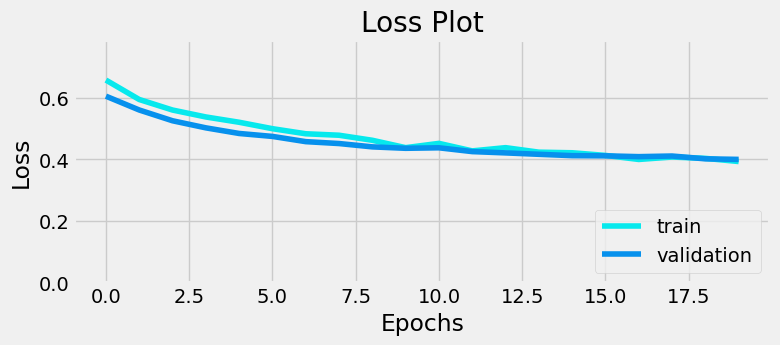

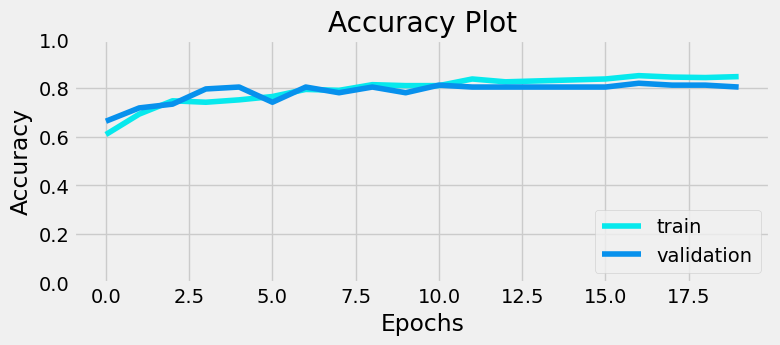

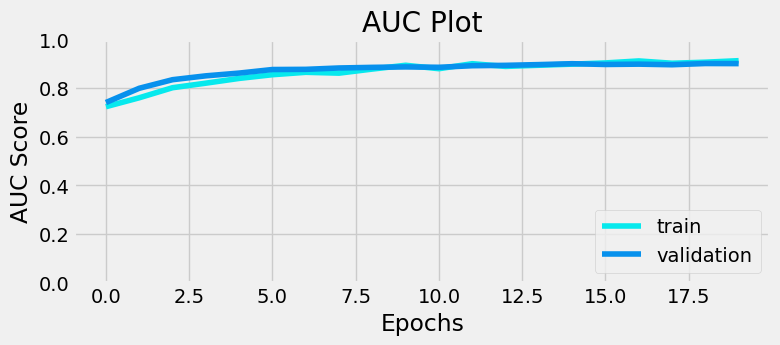

In [50]:
plot_training_hist(resnet152_history)

In [73]:
resnet152.evaluate(valid)

4/4 [==============================] - 16s 4s/step - loss: 0.3995 - accuracy: 0.8047 - precision: 0.8065 - recall: 0.7937 - auc: 0.9011


[0.3994916081428528,
 0.8046875,
 0.8064516186714172,
 0.7936508059501648,
 0.901098906993866]

## EfficientNet

EfficientNet is know to have a better and faster model training compared to ResNet, so we will try to use it in our next modelling

### EfficientNet B0

In [51]:
EFFB0_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [52]:
#Tensorflow Callback
%load_ext tensorboard
logdir = os.path.join("logs", "efficientb0")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# We can also use customized callback, where we customize them on our own
class PrintValTrainRatioCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs): 
    print("val / train : {:.2f}".format(logs['val_loss']/logs['loss']))
    
#Another Additional callbacks (Checkpoint, Early Stopping)
checkpoint_cb = keras.callbacks.ModelCheckpoint("efficientb0_model.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True) 
callbacks = [tensorboard_callback, checkpoint_cb, early_stopping_cb, PrintValTrainRatioCallback()]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [53]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

efficientb0 = create_model(EFFB0_url, 1)

# Compile
efficientb0.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-4),
                     metrics=[metrics])

In [54]:
efficientb0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 1)                 1281      
Total params: 4,050,845
Trainable params: 1,281
Non-trainable params: 4,049,564
_________________________________________________________________


In [55]:
efficientb0_history = efficientb0.fit(
            train_aug,
            callbacks = [callbacks],
            epochs    = 20,
            steps_per_epoch  = len(train),
            validation_data  = valid,
            validation_steps = len(valid))

Epoch 1/20
16/16 [==============================] - 90s 5s/step - loss: 0.6875 - accuracy: 0.5706 - precision: 0.5785 - recall: 0.4594 - auc: 0.7354 - val_loss: 0.6403 - val_accuracy: 0.6641 - val_precision: 0.6351 - val_recall: 0.7460 - val_auc: 0.7424
val / train : 0.95
Epoch 2/20
16/16 [==============================] - 75s 5s/step - loss: 0.6429 - accuracy: 0.6615 - precision: 0.6490 - recall: 0.7697 - auc: 0.7136 - val_loss: 0.5996 - val_accuracy: 0.7422 - val_precision: 0.9167 - val_recall: 0.5238 - val_auc: 0.8364
val / train : 0.95
Epoch 3/20
16/16 [==============================] - 74s 5s/step - loss: 0.6099 - accuracy: 0.7503 - precision: 0.8828 - recall: 0.6135 - auc: 0.7837 - val_loss: 0.5611 - val_accuracy: 0.8203 - val_precision: 0.9348 - val_recall: 0.6825 - val_auc: 0.8703
val / train : 0.94
Epoch 4/20
16/16 [==============================] - 74s 5s/step - loss: 0.5762 - accuracy: 0.7577 - precision: 0.8220 - recall: 0.6487 - auc: 0.8015 - val_loss: 0.5378 - val_accurac

In [56]:

# efficientb0 = keras.models.load_model('efficientb0_model.h5')

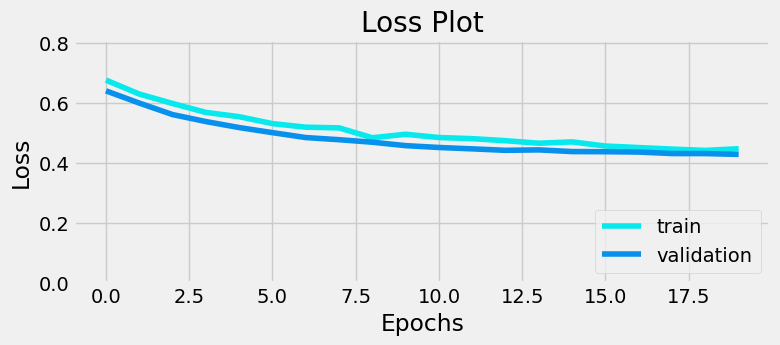

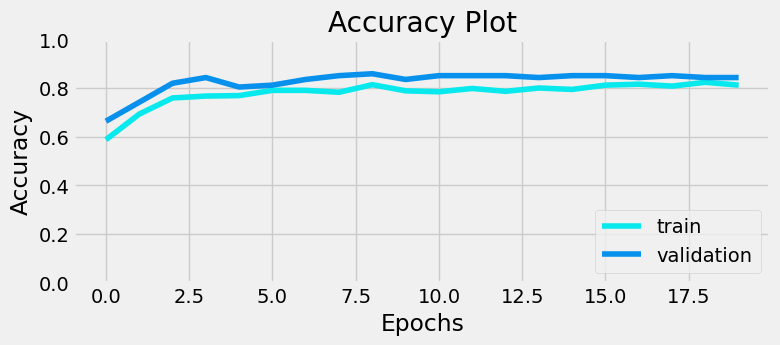

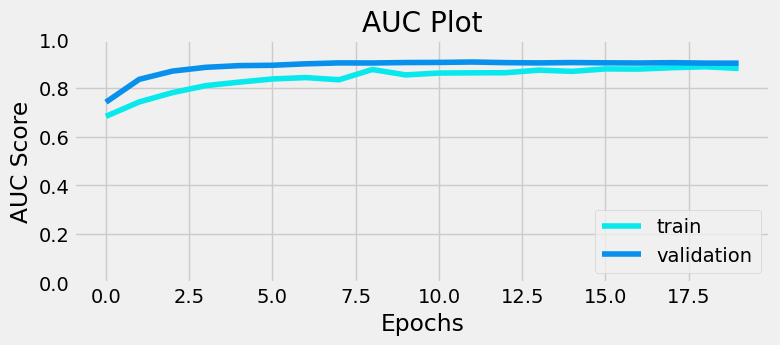

In [57]:
plot_training_hist(efficientb0_history)

In [58]:
efficientb0.evaluate(valid)

4/4 [==============================] - 14s 4s/step - loss: 0.4281 - accuracy: 0.8438 - precision: 0.8909 - recall: 0.7778 - auc: 0.9029


[0.42809242010116577,
 0.84375,
 0.8909090757369995,
 0.7777777910232544,
 0.9029304385185242]

### EfficientNet B1

In [59]:
EFFB1_url = 'https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1'


In [60]:
#Tensorflow Callback
%load_ext tensorboard
logdir = os.path.join("logs", "efficientb1")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# We can also use customized callback, where we customize them on our own
class PrintValTrainRatioCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs): 
    print("val / train : {:.2f}".format(logs['val_loss']/logs['loss']))
    
#Another Additional callbacks (Checkpoint, Early Stopping)
checkpoint_cb = keras.callbacks.ModelCheckpoint("efficientb1_model.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True) 
callbacks = [tensorboard_callback, checkpoint_cb, early_stopping_cb, PrintValTrainRatioCallback()]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [61]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

efficientb1 = create_model(EFFB1_url, 1)

# Compile
efficientb1.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-4),
                     metrics=[metrics])

In [62]:
efficientb1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              6575232   
_________________________________________________________________
output_layer (Dense)         (None, 1)                 1281      
Total params: 6,576,513
Trainable params: 1,281
Non-trainable params: 6,575,232
_________________________________________________________________


The params for the efficientnet-b1 is 1/3 of the resnet50, and known to have a better result. It is really worth to try with less time computation, who knows that we can get a better result in accuracy, loss and auc.

In [63]:
efficient_history = efficientb1.fit(
            train_aug,
            callbacks = [callbacks],
            epochs    = 20,
            steps_per_epoch  = len(train),
            validation_data  = valid,
            validation_steps = len(valid))



Epoch 1/20
16/16 [==============================] - 92s 5s/step - loss: 0.6861 - accuracy: 0.5655 - precision: 0.5462 - recall: 0.6058 - auc: 0.7278 - val_loss: 0.6401 - val_accuracy: 0.7109 - val_precision: 0.6912 - val_recall: 0.7460 - val_auc: 0.7274
val / train : 0.94
Epoch 2/20
16/16 [==============================] - 72s 5s/step - loss: 0.6532 - accuracy: 0.6097 - precision: 0.6041 - recall: 0.6852 - auc: 0.6664 - val_loss: 0.5948 - val_accuracy: 0.7500 - val_precision: 0.8039 - val_recall: 0.6508 - val_auc: 0.8154
val / train : 0.93
Epoch 3/20
16/16 [==============================] - 72s 5s/step - loss: 0.6180 - accuracy: 0.6848 - precision: 0.6822 - recall: 0.5949 - auc: 0.7437 - val_loss: 0.5561 - val_accuracy: 0.8047 - val_precision: 0.8393 - val_recall: 0.7460 - val_auc: 0.8578
val / train : 0.91
Epoch 4/20
16/16 [==============================] - 73s 5s/step - loss: 0.5923 - accuracy: 0.7015 - precision: 0.6945 - recall: 0.6812 - auc: 0.7882 - val_loss: 0.5313 - val_accurac

In [64]:
# efficientb1 = keras.models.load_model('efficientb1_model.h5')

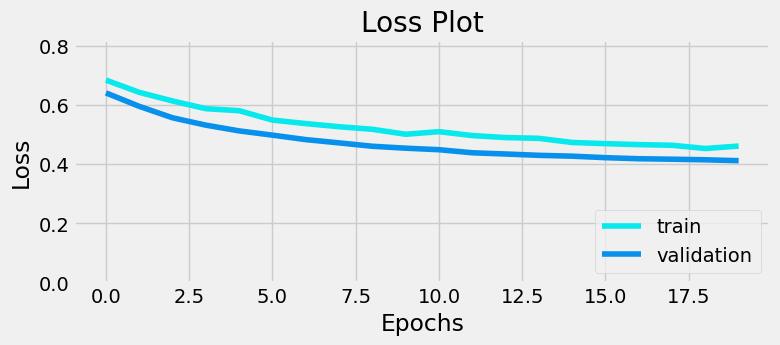

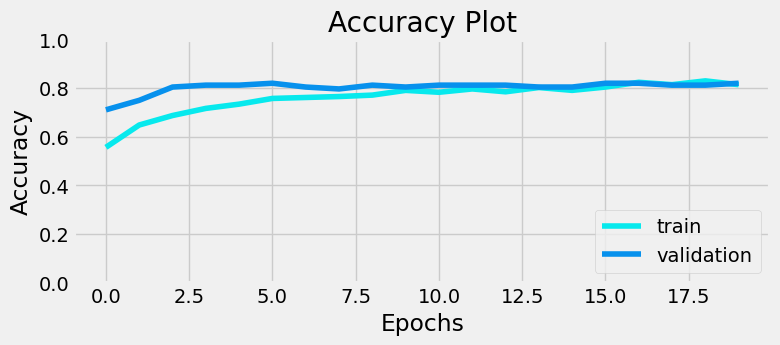

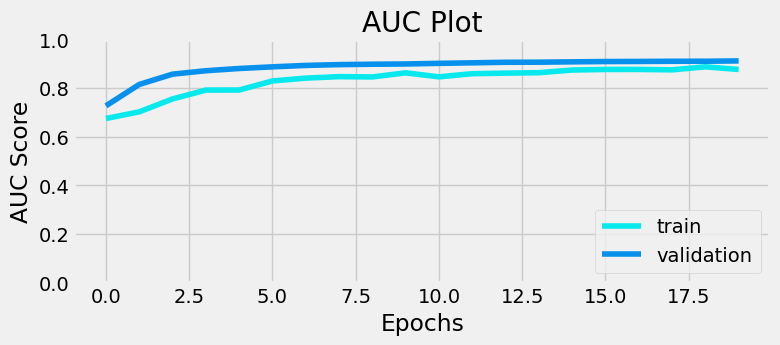

In [65]:
plot_training_hist(efficient_history)

In [66]:
efficientb1.evaluate(valid)

4/4 [==============================] - 14s 4s/step - loss: 0.4113 - accuracy: 0.8203 - precision: 0.8226 - recall: 0.8095 - auc: 0.9122


[0.41132989525794983,
 0.8203125,
 0.8225806355476379,
 0.8095238208770752,
 0.9122099876403809]

## DenseNet

In [67]:
#Tensorflow Callback
%load_ext tensorboard
logdir = os.path.join("logs", "densenet121")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# We can also use customized callback, where we customize them on our own
class PrintValTrainRatioCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs): 
    print("val / train : {:.2f}".format(logs['val_loss']/logs['loss']))
    
#Another Additional callbacks (Checkpoint, Early Stopping)
checkpoint_cb = keras.callbacks.ModelCheckpoint("densenet121.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True) 
callbacks = [tensorboard_callback, checkpoint_cb, early_stopping_cb, PrintValTrainRatioCallback()]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [68]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
from keras import layers

base_model = tf.keras.applications.densenet.DenseNet121(weights='imagenet', include_top = False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
out = base_model(inputs, training=False)
out = layers.GlobalMaxPooling2D()(out)
out = layers.Dense(1, activation='sigmoid', name='output_layer')(out)
model_dense = keras.Model(inputs, out)

model_dense.compile(optimizer = keras.optimizers.Adam(learning_rate = 5e-4), loss = 'binary_crossentropy', metrics = [metrics])

29089792/29084464 [==============================] - 0s 0us/step


In [72]:
model_dense.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_max_pooling2d (Global (None, 1024)              0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________


In [69]:
dense121_history = model_dense.fit(
            train_aug,
            callbacks = [callbacks],
            epochs    = 20,
            steps_per_epoch  = len(train),
            validation_data  = valid,
            validation_steps = len(valid))

Epoch 1/20
16/16 [==============================] - 85s 5s/step - loss: 4.0649 - accuracy: 0.5297 - precision: 0.4978 - recall: 0.3248 - auc: 0.5772 - val_loss: 1.0149 - val_accuracy: 0.5156 - val_precision: 0.5052 - val_recall: 0.7778 - val_auc: 0.5244
val / train : 0.35
Epoch 2/20
16/16 [==============================] - 72s 5s/step - loss: 1.1847 - accuracy: 0.5318 - precision: 0.5196 - recall: 0.8967 - auc: 0.5277 - val_loss: 0.9139 - val_accuracy: 0.4766 - val_precision: 0.4545 - val_recall: 0.3175 - val_auc: 0.5377
val / train : 0.76
Epoch 3/20
16/16 [==============================] - 72s 5s/step - loss: 0.9769 - accuracy: 0.5114 - precision: 0.5342 - recall: 0.3056 - auc: 0.5271 - val_loss: 0.8375 - val_accuracy: 0.5078 - val_precision: 0.5000 - val_recall: 0.5556 - val_auc: 0.5711
val / train : 0.87
Epoch 4/20
16/16 [==============================] - 72s 5s/step - loss: 0.8981 - accuracy: 0.5283 - precision: 0.5260 - recall: 0.5931 - auc: 0.5553 - val_loss: 0.7988 - val_accurac

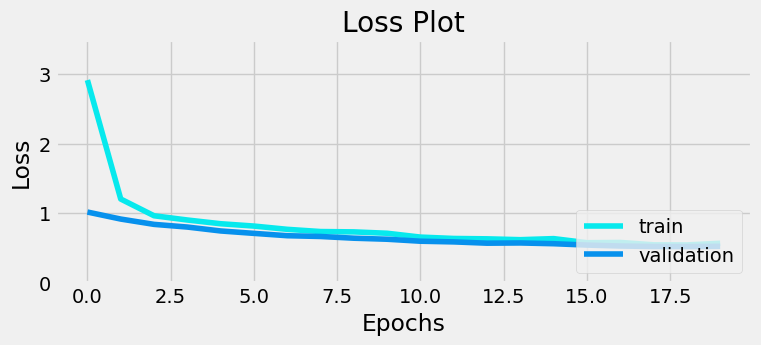

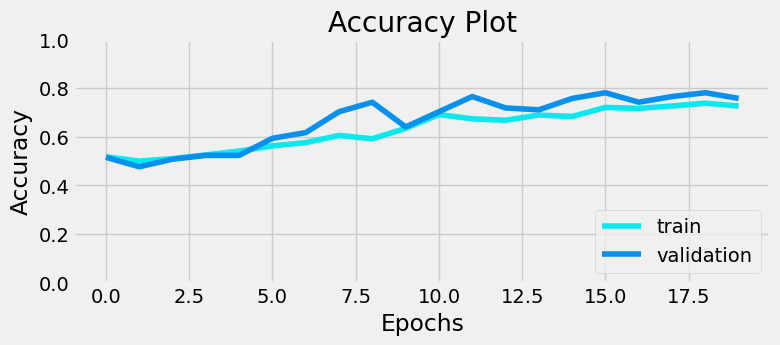

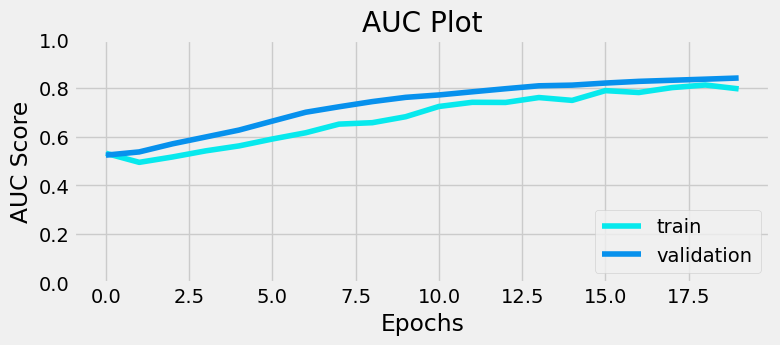

In [70]:
plot_training_hist(dense121_history)

In [71]:
model_dense.evaluate(valid)

4/4 [==============================] - 14s 3s/step - loss: 0.5221 - accuracy: 0.7578 - precision: 0.7105 - recall: 0.8571 - auc: 0.8419


[0.5220533609390259,
 0.7578125,
 0.7105262875556946,
 0.8571428656578064,
 0.8418803811073303]

## Modelling Conclusion

Model

After trying several pretrained models, we get the ResNet50 pretrained model as the most stable, less overfit and good in getting the best scores in specified metrics (accuracy, auc, recall). Hence, we will use this model for further hyperparameter tuning, or adding layers.

|Model|Loss | Acc | Precision | Recall | AUC | 
|---   |---   |---   |---   |--- |--- |
|Baseline|0.422|0.820|0.770|0.904|0.915|
|ResNet50 V2|0.381|0.859|0.8571|0.8571|0.916|
|ResNet 151 V2|0.399|0.804|0.806|0.793|0.901|
|EfficientNetB0|0.428|0.843|0.890|0.777|0.902|
|EfficientNetB1|0.411|0.820|0.822|0.809|0.912|
|DenseNet121|0.522|0.757|0.7105|0.8571|0.842|

These table is generated from the previous models when it is programmed to evaluate validation data. ResNet50 V2 outperformed all the other models with the least loss, and highest score in all other metrics.